In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from IPython.display import display
import os
import sys
from datetime import date
import json
import numpy as np
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

ModuleNotFoundError: No module named 'pingouin'

In [ ]:
!jt -r

In [2]:
DATA_PATH = '../data'
PROCESSED_DATA_PATH = '../preprocessed_data/'
PLOT_PATH = './plots/data_quality/'
RESULTS_PATH = './plots/results/'
os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(RESULTS_PATH), exist_ok=True)

uses_leap_motion = True
number_of_trials_per_block = 48

In [ ]:
os.getcwd()

In [3]:
sns.set(style='ticks', context='poster', palette='muted')

In [4]:
# SteamVR
if (not uses_leap_motion):
    raw_measurement_files = glob.glob(f'{DATA_PATH}/2*/SubjectData/STEAMVR/*DataOfBlock*')
    raw_metadata_files = glob.glob(f'{DATA_PATH}/2*/SubjectData/STEAMVR/*MetaData*')

# LeapMotion
else:
    raw_measurement_files = glob.glob(f'{DATA_PATH}/SubjectID_*/*DataOfBlock*')
    raw_metadata_files = glob.glob(f'{DATA_PATH}//SubjectID_*/*MetaData*')

display(raw_measurement_files)
display(raw_metadata_files)

['../data\\SubjectID_31_LeapMotion\\SubjectID_31_DataOfBlock_1_Datetime_2020-10-28_13-35.json',
 '../data\\SubjectID_31_LeapMotion\\SubjectID_31_DataOfBlock_2_Datetime_2020-10-28_13-35.json',
 '../data\\SubjectID_31_LeapMotion\\SubjectID_31_DataOfBlock_3_Datetime_2020-10-28_13-35.json',
 '../data\\SubjectID_32_LeapMotion\\SubjectID_32_DataOfBlock_1_Datetime_2020-10-30_16-17.json',
 '../data\\SubjectID_32_LeapMotion\\SubjectID_32_DataOfBlock_2_Datetime_2020-10-30_16-17.json',
 '../data\\SubjectID_32_LeapMotion\\SubjectID_32_DataOfBlock_3_Datetime_2020-10-30_16-17.json',
 '../data\\SubjectID_33_LeapMotion\\SubjectID_33_DataOfBlock_1_Datetime_2020-11-05_13-12.json',
 '../data\\SubjectID_33_LeapMotion\\SubjectID_33_DataOfBlock_2_Datetime_2020-11-05_13-12.json',
 '../data\\SubjectID_33_LeapMotion\\SubjectID_33_DataOfBlock_3_Datetime_2020-11-05_13-12.json',
 '../data\\SubjectID_34_LeapMotion\\SubjectID_34_DataOfBlock_1_Datetime_2020-11-06_11-23.json',
 '../data\\SubjectID_34_LeapMotion\\Subj

['../data\\SubjectID_31_LeapMotion\\SubjectID_31_MetaData_Datetime_2020-10-28_13-35.json',
 '../data\\SubjectID_32_LeapMotion\\SubjectID_32_MetaData_Datetime_2020-10-30_16-17.json',
 '../data\\SubjectID_33_LeapMotion\\SubjectID_33_MetaData_Datetime_2020-11-05_13-12.json',
 '../data\\SubjectID_34_LeapMotion\\SubjectID_34_MetaData_Datetime_2020-11-06_11-50.json',
 '../data\\SubjectID_35_LeapMotion\\SubjectID_35_MetaData_Datetime_2020-11-10_14-18.json',
 '../data\\SubjectID_36_LeapMotion\\SubjectID_36_MetaData_Datetime_2020-11-11_12-05.json',
 '../data\\SubjectID_37_LeapMotion\\SubjectID_37_MetaData_Datetime_2020-11-11_14-41.json',
 '../data\\SubjectID_38_LeapMotion\\SubjectID_38_MetaData_Datetime_2020-11-12_10-18.json',
 '../data\\SubjectID_39_LeapMotion\\SubjectID_39_MetaData_Datetime_2020-11-12_11-52.json',
 '../data\\SubjectID_40_LeapMotion\\SubjectID_40_MetaData_Datetime_2020-11-12_13-37.json',
 '../data\\SubjectID_41_LeapMotion\\SubjectID_41_MetaData_Datetime_2020-11-12_14-55.json',

In [6]:
# Init dataframes with all samples and with all meta data 
all_trials_df = pd.DataFrame()
all_meta_df = pd.DataFrame()

# Read files 
for measurement_file in raw_measurement_files: # reading only one file for now
    
    try:
        with open(measurement_file, 'r') as measurement_json_filereader:
            measurement_json = json.loads(measurement_json_filereader.read())
        print("Processing file \"" + measurement_file + "\".")
    
    except Exception as e:
        print(e)
        continue
    
    # Extract basic data from measurement file
    subject_id = measurement_json['subjectId']
    block_id = measurement_json['blockNumber']
    
    # Find meta data 
    meta_data_substring = "SubjectID_" + str(subject_id)
    meta_data_files = [filename for filename in raw_metadata_files if meta_data_substring in filename]
    
    # Make sure Meta data is proper, open 
    if (len(meta_data_files) != 1):
#         raise Exception("Multiple or no Meta Data files for SubjectID " + str(subID))
        print(' meta file not found ')
    with open(meta_data_files[0], 'r') as meta_json_filereader:
        meta_json = json.loads(meta_json_filereader.read())
    
    # Dataframe from read meta json 
    meta_json_df = pd.json_normalize(meta_json)
    
    # Rename column and resort for better readability in the csv 
    meta_json_df.rename({'allToolDetails':'toolDetails'}, axis=1, inplace=True)
    meta_json_df = meta_json_df.sort_index(axis=1)
    
    # Extract more data from meta file 
    gender = meta_json['subjectGender']
    age = meta_json['subjectAge']
    handedness = meta_json['subjectHandedness']

    # Append meta data that corresponds to current measurement 
    all_meta_df = pd.concat([all_meta_df, meta_json_df], ignore_index=True)
    
    # Trial temporary data
    trial_df = pd.DataFrame()
    
    # Append trials to combined trials
    for trial_number, trial in enumerate(measurement_json['blockTrials']):        
        # Data from measurements 
        trial_df = pd.json_normalize(data=trial['dataPoints'])
        trial_df['trial_id'] = trial_number + 1 # start trial enumeration at 1
        trial_df['utcon'] = trial['utcon']
        trial_df['tool_id'] = trial['toolId']
        trial_df['tool_name'] = trial['toolName']
        trial_df['cue_orientation_id'] = trial['cueOrientationId']
        trial_df['cue_orientation_name'] = trial['cueOrientationName']
        trial_df['cue_name'] = trial['cueName']
        trial_df['handle_orientation'] = trial['toolHandleOrientation']
        trial_df['trial_duration'] = (
            trial['dataPoints'][-1]['timeStampDataPointEnd'] 
            - trial['dataPoints'][0]['timeStampDataPointStart']
        )        
        
        # Data from metadata
        trial_df['subject_id'] = subject_id
        trial_df['block_id'] = block_id
#         trial_df['gender'] = gender
#         trial_df['age'] = age
#         trial_df['handedness'] = handedness
        trial_df['is_leap_motion'] = uses_leap_motion
    
        # Append 
        all_trials_df = pd.concat([all_trials_df, trial_df], ignore_index = True)     


Processing file "../data\SubjectID_31_LeapMotion\SubjectID_31_DataOfBlock_1_Datetime_2020-10-28_13-35.json".
Processing file "../data\SubjectID_31_LeapMotion\SubjectID_31_DataOfBlock_2_Datetime_2020-10-28_13-35.json".
Processing file "../data\SubjectID_31_LeapMotion\SubjectID_31_DataOfBlock_3_Datetime_2020-10-28_13-35.json".
Processing file "../data\SubjectID_32_LeapMotion\SubjectID_32_DataOfBlock_1_Datetime_2020-10-30_16-17.json".
Processing file "../data\SubjectID_32_LeapMotion\SubjectID_32_DataOfBlock_2_Datetime_2020-10-30_16-17.json".
Processing file "../data\SubjectID_32_LeapMotion\SubjectID_32_DataOfBlock_3_Datetime_2020-10-30_16-17.json".
Processing file "../data\SubjectID_33_LeapMotion\SubjectID_33_DataOfBlock_1_Datetime_2020-11-05_13-12.json".
Processing file "../data\SubjectID_33_LeapMotion\SubjectID_33_DataOfBlock_2_Datetime_2020-11-05_13-12.json".
Processing file "../data\SubjectID_33_LeapMotion\SubjectID_33_DataOfBlock_3_Datetime_2020-11-05_13-12.json".
Expecting ',' delim

Processing file "../data\SubjectID_56_LeapMotion\SubjectID_56_DataOfBlock_2_Datetime_2020-12-03_16-00.json".
Processing file "../data\SubjectID_56_LeapMotion\SubjectID_56_DataOfBlock_3_Datetime_2020-12-03_16-00.json".
Processing file "../data\SubjectID_57_LeapMotion\SubjectID_57_DataOfBlock_1_Datetime_2020-12-04_15-52.json".
Processing file "../data\SubjectID_57_LeapMotion\SubjectID_57_DataOfBlock_2_Datetime_2020-12-04_15-52.json".
Processing file "../data\SubjectID_57_LeapMotion\SubjectID_57_DataOfBlock_3_Datetime_2020-12-04_15-52.json".
Processing file "../data\SubjectID_58_LeapMotion\SubjectID_58_DataOfBlock_1_Datetime_2020-12-04_17-23.json".
Processing file "../data\SubjectID_58_LeapMotion\SubjectID_58_DataOfBlock_2_Datetime_2020-12-04_17-23.json".
Processing file "../data\SubjectID_58_LeapMotion\SubjectID_58_DataOfBlock_3_Datetime_2020-12-04_17-23.json".
Processing file "../data\SubjectID_59_LeapMotion\SubjectID_59_DataOfBlock_1_Datetime_2020-12-08_16-25.json".
Processing file "..

In [7]:
# Drop categories in combined trials that are not used when using SteamVR/ LeapMotion
try:
    if uses_leap_motion: # leap 
        all_trials_df.drop(
            columns = [col for col in all_trials_df.columns if col.startswith('controller')],
            inplace=True
        )

    else: # steamvr 
        all_trials_df.drop(
            columns = [col for col in all_trials_df.columns if 'leap' in col], 
            inplace=True
        )
except Exception as e:
    print(e)

In [8]:
all_trials_df.to_csv(f'{PROCESSED_DATA_PATH}/00_trials_leap.csv', index=False)
all_meta_df.to_csv(f'{PROCESSED_DATA_PATH}/00_meta_leap.csv', index=True)

In [9]:
del all_trials_df
del all_meta_df

In [3]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/00_trials_leap.csv')

In [4]:
display(samples_df.columns)

Index(['timeStampDataPointStart', 'timeStampDataPointEnd',
       'timeDataPointBeforeGazeRayCasting', 'eyeOpennessLeft',
       'eyeOpennessRight', 'pupilDiameterMillimetersLeft',
       'pupilDiameterMillimetersRight', 'hitObjectNameCombinedEyes',
       'hitObjectNameLeftEye', 'hitObjectNameRightEye', 'leapIsGrasping',
       'leapGrabStrength', 'leapGrabAngle', 'leapPinchStrength',
       'toolIsCurrentlyAttachedToHand', 'closestAttachmentPointOnToolToHand',
       'toolIsCurrentlyDisplayedOnTable', 'eyePositionCombinedWorld.x',
       'eyePositionCombinedWorld.y', 'eyePositionCombinedWorld.z',
       'eyeDirectionCombinedWorld.x', 'eyeDirectionCombinedWorld.y',
       'eyeDirectionCombinedWorld.z', 'eyePositionLeftWorld.x',
       'eyePositionLeftWorld.y', 'eyePositionLeftWorld.z',
       'eyeDirectionLeftWorld.x', 'eyeDirectionLeftWorld.y',
       'eyeDirectionLeftWorld.z', 'eyePositionRightWorld.x',
       'eyePositionRightWorld.y', 'eyePositionRightWorld.z',
       'eyeDirectio

In [5]:
samples_df['timestamp'] = pd.to_datetime(samples_df['timeDataPointBeforeGazeRayCasting'], origin='unix', unit='s')

In [11]:
samples_df = (
    samples_df
    .query('subject_id==60')
    
)

In [12]:
display(samples_df.trial_id.unique())
display(samples_df.tool_name.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)

array(['flowercutter', 'trowel', 'screwdriver', 'paletteknife', 'fork',
       'spokewrench', 'daisygrubber', 'paintbrush', 'zester', 'spatula',
       'wrench', 'fishscaler'], dtype=object)

In [13]:
display(samples_df.subject_id.nunique())

1

In [14]:
samples_df['trial_id'] = (
    number_of_trials_per_block*(samples_df['block_id'] - 1) 
    + samples_df['trial_id']
)
samples_df.trial_id.unique()

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144], dtype=int64)

In [14]:
display(samples_df.groupby(['subject_id']).trial_id.nunique())
display(samples_df.hitObjectNameCombinedEyes.unique())
display(samples_df.tool_name.unique())

subject_id
31    144
32    144
33    144
34     96
35    144
36    144
37    144
38    144
39    144
40    144
41    144
42    144
43    144
44    144
45    144
46     96
47    144
48    144
49    144
50    144
51    144
52    144
53    144
54    144
55    144
56    144
57    144
58    144
59    144
60    144
61    144
Name: trial_id, dtype: int64

array(['Wall front', 'Cue', 'Floor', 'WorkbenchMultipleSmallOnes',
       'FlowercutterHandleCollider', 'FlowercutterEffectorCollider',
       'Contact Fingerbone', 'Contact Palm Bone',
       'TrowelEffectorCollider', 'TrowelHandleCollider', 'ButtonTopCap',
       'ButtonBaseScrews', 'ButtonBaseTop', 'ScrewdriverHandleCollider',
       'ScrewdriverEffectorCollider', 'PaletteknifeEffectorCollider',
       'PaletteknifeHandleCollider', 'ForkEffectorCollider',
       'ForkHandleCollider', 'SpokewrenchHandleCollider',
       'SpokewrenchEffectorCollider', 'DaisygrubberEffectorCollider',
       'DaisygrubberHandleCollider', 'ButtonBaseMetalRing',
       'PaintbrushEffectorCollider', 'PaintbrushHandleCollider',
       'ZesterHandleCollider', 'ZesterEffectorCollider',
       'SpatulaEffectorCollider', 'SpatulaHandleCollider',
       'WrenchHandleCollider', 'WrenchEffectorCollider',
       'ButtonBaseBottom', 'FishscalerEffectorCollider',
       'FishscalerHandleCollider', nan, 'Wall left', '

array(['flowercutter', 'trowel', 'screwdriver', 'paletteknife', 'fork',
       'spokewrench', 'daisygrubber', 'paintbrush', 'zester', 'spatula',
       'wrench', 'fishscaler'], dtype=object)

In [ ]:
samples_df.head()

In [ ]:
samples_df['new_eye_hit'] = np.nan
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/01_trials_leap_offline_raycasting.csv', index=False)

In [ ]:
[print(idx, col) for idx, col in enumerate(samples_df.columns)]

In [ ]:
samples_df = pd.read_csv(
    f'{PROCESSED_DATA_PATH}/01_trials_leap_casted.csv',
    parse_dates=['timeStampDataPointStart', 'timestamp']
)

In [ ]:
samples_df.info()

In [15]:
# display(samples_df.new_eye_hit.unique())
display(samples_df.tool_name.unique())
display(samples_df.cue_name.unique())

array(['flowercutter', 'trowel', 'screwdriver', 'paletteknife', 'fork',
       'spokewrench', 'daisygrubber', 'paintbrush', 'zester', 'spatula',
       'wrench', 'fishscaler'], dtype=object)

array(['use', 'lift'], dtype=object)

In [16]:
tool_names = ['fork','paletteknife','fishscaler','daisygrubber','trowel','screwdriver', \
             'flowercutter','spatula','zester','spokewrench','paintbrush','wrench']


familiar_tools = ['fork','trowel','screwdriver','spatula',
                     'paintbrush','wrench']

# Assign familiarity to tool 
def familiarityCheck(tool):   
    if tool in familiar_tools:
        return 'familiar'
    else:
        return 'unfamiliar'
    
    
# Add familarity column to trials 
samples_df['familiarity'] = samples_df['tool_name'].apply(familiarityCheck)

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
hit_replacement_dictionary = {}
hit_names_other = [] 

# Replace nans with empty string 
samples_df.hitObjectNameCombinedEyes.fillna("",inplace=True)

for hit_name in samples_df.hitObjectNameCombinedEyes.unique():
    try:
        if ("wall" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "wall"

        elif ("finger_" in hit_name.lower() or "thumb_" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "hand"

        elif ("button" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "triggerbutton"

        elif ("floor" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "floor"

        elif ("cue" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "cue"

        elif ("workbench" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "workbench"

        elif ("effector" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "effector"

        elif ("handle" in hit_name.lower()):
            hit_replacement_dictionary[hit_name] = "handle"

        else:
            hit_names_other.append(hit_name)
            hit_replacement_dictionary[hit_name] = "other"
    except Exception as e:
        print(e)
        print(hit_name)
        
    
print("Hit Replacement Dict:")
print(hit_replacement_dictionary)

print("Hit names other than mapped:")
print(hit_names_other)


# Apply map 
samples_df['hit_object'] = samples_df['hitObjectNameCombinedEyes'].map(hit_replacement_dictionary)
# samples_df['hit_object_new'] = samples_df['new_eye_hit'].map(hit_replacement_dictionary)

samples_df['hit_object'].unique()

Hit Replacement Dict:
{'Wall front': 'wall', 'Cue': 'cue', 'Floor': 'floor', 'WorkbenchMultipleSmallOnes': 'workbench', 'FlowercutterHandleCollider': 'handle', 'FlowercutterEffectorCollider': 'effector', 'Contact Fingerbone': 'other', 'Wall left': 'wall', 'Wall right': 'wall', 'ButtonTopCap': 'triggerbutton', 'ButtonBaseScrews': 'triggerbutton', 'Contact Palm Bone': 'other', 'ButtonBaseTop': 'triggerbutton', 'TrowelHandleCollider': 'handle', 'TrowelEffectorCollider': 'effector', 'ButtonBaseBottom': 'triggerbutton', 'ScrewdriverHandleCollider': 'handle', 'ScrewdriverEffectorCollider': 'effector', 'ButtonBaseMetalRing': 'triggerbutton', 'PaletteknifeHandleCollider': 'handle', 'PaletteknifeEffectorCollider': 'effector', 'ForkEffectorCollider': 'effector', 'ForkHandleCollider': 'handle', 'SpokewrenchHandleCollider': 'handle', 'SpokewrenchEffectorCollider': 'effector', 'DaisygrubberEffectorCollider': 'effector', 'DaisygrubberHandleCollider': 'handle', 'PaintbrushEffectorCollider': 'effector

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array(['wall', 'cue', 'floor', 'workbench', 'handle', 'effector', 'other',
       'triggerbutton'], dtype=object)

In [20]:
samples_df.hit_object.value_counts()

effector         59464
handle           54201
workbench        31864
cue              17289
floor            12016
triggerbutton     6259
other             4028
wall              3119
Name: hit_object, dtype: int64

In [21]:
samples_df.to_csv('NEC21_SeatedParticipant.csv',
                 index=False)

In [ ]:
samples_df.hit_object_new.value_counts()

In [25]:
samples_df.head()

timeStampDataPointStart  timeStampDataPointEnd  \
0             1.603889e+09           1.603889e+09   
1             1.603889e+09           1.603889e+09   
2             1.603889e+09           1.603889e+09   
3             1.603889e+09           1.603889e+09   
4             1.603889e+09           1.603889e+09   

   timeDataPointBeforeGazeRayCasting  eyeOpennessLeft  eyeOpennessRight  \
0                       1.603889e+09              1.0               1.0   
1                       1.603889e+09              1.0               1.0   
2                       1.603889e+09              1.0               1.0   
3                       1.603889e+09              1.0               1.0   
4                       1.603889e+09              1.0               1.0   

   pupilDiameterMillimetersLeft  pupilDiameterMillimetersRight  \
0                      2.553558                       2.996017   
1                      2.519913                       2.884064   
2                      2.661087                       2.874954   
3                      2.661087                       2.874954   
4                      2.674240                       2.838699   

  hitObjectNameCombinedEyes hitObjectNameLeftEye hitObjectNameRightEye  ...  \
0                Wall front           Wall front            Wall front  ...   
1                Wall front           Wall front            Wall front  ...   
2                       Cue                  Cue                   Cue  ...   
3                       Cue                  Cue                   Cue  ...   
4                       Cue                  Cue                   Cue  ...   

   cue_orientation_id  cue_orientation_name  cue_name  handle_orientation  \
0                   3               leftuse       use                left   
1                   3               leftuse       use                left   
2                   3               leftuse       use                left   
3                   3               leftuse       use                left   
4                   3               leftuse       use                left   

   trial_duration subject_id  block_id  is_leap_motion  familiarity  \
0       23.049129         31         1            True   unfamiliar   
1       23.049129         31         1            True   unfamiliar   
2       23.049129         31         1            True   unfamiliar   
3       23.049129         31         1            True   unfamiliar   
4       23.049129         31         1            True   unfamiliar   

   hit_object  
0        wall  
1        wall  
2         cue  
3         cue  
4         cue  

[5 rows x 91 columns]

In [19]:
# Elapsed time since trial start 
samples_df.set_index('timestamp', inplace=True)
samples_df['time_since_start'] = (
    samples_df
    .groupby(['subject_id', 'trial_id'], as_index=False)    
    .transform(lambda x:(x.index - x.index[0])/np.timedelta64(1,'s')) 
    .timeStampDataPointStart
) 
samples_df.reset_index(inplace=True)

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


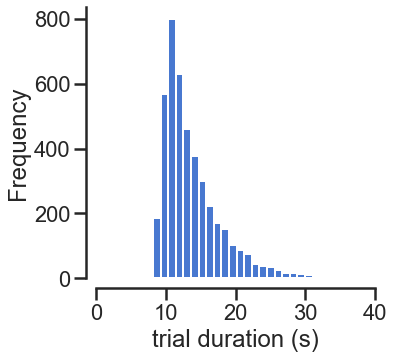

In [33]:
_, ax = plt.subplots(figsize=(5,5))
(
    samples_df
    .groupby(['subject_id', 'trial_id'])
    .time_since_start
    .last()
    .plot(kind='hist', bins=50, ax=ax)

)
sns.despine(offset=10)
ax.set(
    xlabel='trial duration (s)',
    xlim=(0,40),
#     ylim=(0,0.2)
);

In [ ]:
samples_df.toolIsCurrentlyDisplayedOnTable.value_counts()

In [ ]:
framerate_df = (
    samples_df
    .reset_index()
    .groupby(['subject_id','trial_id'])
    .timestamp 
    .apply(lambda x: 1/np.mean((x-x.shift(1))/np.timedelta64(1, 's'))) # mean(framerate) = 1 / mean(time of datapoint - time of last datapoint)
    .rename('framerate')
    .reset_index()
)

display(framerate_df.groupby('subject_id')['framerate'].describe())
#display(framerate_df)

# # Plot
# # Standard deviation: Per trial based

_, ax = plt.subplots(1,1,figsize=(20,5))
sns.pointplot(data=framerate_df, x='subject_id', y='framerate', color='b',
              errwidth=2, capsize=0, saturation=0.5, ci='sd')
ax.set_ylabel("Hz")
ax.set_ylim(0,100)
ax.set_xlabel("Subject ID")
line = ax.axhline(y=90, ls='-.', color='red', lw=3,
                          label='Intended frame rate: 90Hz')
plt.legend(handles=[line])
plt.xticks(rotation=0, fontsize=25)
plt.title('Frame Rates')
# plt.savefig(f'{PLOT_PATH}/frameRatesDottedLine.png',
#                  transparent=True, bbox_inches='tight', quality=95)
sns.despine(offset=10)

In [34]:
samples_df['eye_theta_h'] = np.arctan2(
    samples_df['eyeDirectionCombinedWorld.z'], # was x in orig code
    samples_df['eyeDirectionCombinedWorld.x']
) # was z 
samples_df['eye_theta_v'] = np.arctan2(
    samples_df['eyeDirectionCombinedWorld.y'], # was y 
    samples_df['eyeDirectionCombinedWorld.x']
) # was z 

samples_df['head_theta_h'] = np.arctan2(
    samples_df['hmdDirectionForward.z'], # was x in orig code
    samples_df['hmdDirectionForward.x']
) # was z
samples_df['head_theta_v'] = np.arctan2(
    samples_df['hmdDirectionForward.y'], # was y
    samples_df['hmdDirectionForward.x']
) # was z

In [35]:
# Calculate head & eye velocity
# v = delta_s / delta_t, delta_s = theta change, delta_s = time change 
samples_df = samples_df.sort_values('timestamp')

samples_df['eye_vel_h'] = (samples_df
                                .groupby(['subject_id','trial_id'])
                                .eye_theta_h
                                .apply(lambda x: x.diff()) # difference between current and previous element
                          )/(samples_df
                                .groupby(['subject_id','trial_id'])
                                .timestamp
                                .apply(lambda x: x.diff()/np.timedelta64(1, 's')))

samples_df['eye_vel_v'] = (samples_df
                                .groupby(['subject_id','trial_id'])
                                .eye_theta_v
                                .apply(lambda x: x.diff())
                          )/(samples_df
                                .groupby(['subject_id','trial_id'])
                                .timestamp
                                .apply(lambda x: x.diff()/np.timedelta64(1, 's')))

samples_df['head_vel_h'] = (samples_df
                                .groupby(['subject_id','trial_id'])
                                .head_theta_h
                                .apply(lambda x: x.diff())
                          )/(samples_df
                                .groupby(['subject_id','trial_id'])
                                .timestamp
                                .apply(lambda x: x.diff()/np.timedelta64(1, 's')))

samples_df['head_vel_v'] = (samples_df
                                .groupby(['subject_id','trial_id'])
                                .head_theta_v
                                .apply(lambda x: x.diff())
                          )/(samples_df
                                .groupby(['subject_id','trial_id'])
                                .timestamp
                                .apply(lambda x: x.diff()/np.timedelta64(1, 's')))


samples_df['eye_angular_vel'] = np.sqrt(samples_df.eye_vel_h**2 + samples_df.eye_vel_v**2)
samples_df['head_angular_vel'] = np.sqrt(samples_df.head_vel_h**2 + samples_df.head_vel_v**2)
samples_df.dropna(axis=0,subset=['eye_angular_vel', 'eye_vel_h', 'head_angular_vel', 'head_vel_h'], inplace=True)

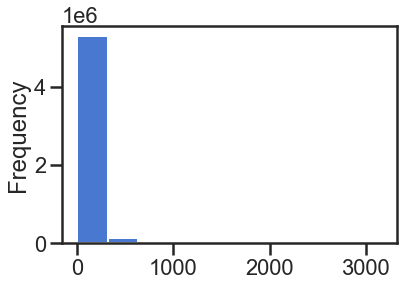

In [39]:
samples_df.eye_angular_vel.plot(kind='hist',)

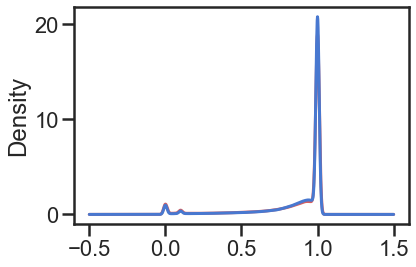

In [37]:
samples_df['eyeOpennessLeft'].plot(kind='kde', color='r')
samples_df['eyeOpennessRight'].plot(kind='kde', color='b')

In [38]:
def simple_mad(angular_vel, thresh = 5):
    # Check input format 
    if len(angular_vel.shape) == 1:
        angular_vel = angular_vel[:,None]
    
    # Median of input 
    median = np.median(angular_vel)
    
    # Absolute difference of input values from median 
    diff = (angular_vel - median)**2
    diff = np.sqrt(diff)
    
    # Median of absolute difference 
    med_abs_deviation = np.median(diff)
    
    # New threshold is median + coefficient * median of absolute difference 
    saccade_thresh = median + thresh*med_abs_deviation
    return saccade_thresh


def at_mad(angular_vel, th_0=200):
    threshs = []
    thresh_coeff = 3*1.48
    
    # Check input format 
    if len(angular_vel.shape) == 1:
        angular_vel = angular_vel[:,None]

    # As long as difference between newly calculated threshold and previous threshold is greater 1
    while True:
        threshs.append(th_0) # store current threshold
        angular_vel = angular_vel[angular_vel < th_0] # cut all values above current threshold      
        median = np.median(angular_vel) # median of values that are < threshold
        diff = (angular_vel - median)**2 # absolute difference between values and median
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff) # median of absolute difference 
        th_1 = median + thresh_coeff*med_abs_deviation # new thresh = median + coefficient * median absolute deviation
#         print(th_0, th_1)
        if (th_0 - th_1)>1: # make new thresh current thresh and restart in loop             
            th_0 = th_1
        else: # difference between threshs small enough, new thresh becomes saccade thresh 
            saccade_thresh = th_1 
            threshs.append(saccade_thresh)
            break
    return saccade_thresh

In [ ]:
for subject_id in samples_df.subject_id.unique():
    os.makedirs(os.path.dirname(f'{PLOT_PATH}/sub_{subject_id}/'), exist_ok=True)
    for trial_id in samples_df.query('subject_id==@subject_id').trial_id.unique():
        tmpdf = samples_df.query('subject_id==@subject_id and trial_id==@trial_id') # trialId==98')

        if tmpdf.shape[0] == 0:
            continue

        mad_1 = at_mad(tmpdf.eye_angular_vel)

#         print(mad_1)

        tmpdf.loc[tmpdf.eye_angular_vel>400, 'eye_angular_vel'] = np.nan
        tmpdf.loc[tmpdf.head_angular_vel>400, 'head_angular_vel'] = np.nan
    #     tmpdf.eyeOpennessLeft *= 10
        tmpdf.toolIsCurrentlyDisplayedOnTable *=30
        tmpdf.toolIsCurrentlyAttachedToHand *=20
        tmpdf['effector_fix'] = (tmpdf.hit_object == "effector")*10
        tmpdf['handle_fix'] = (tmpdf.hit_object == "handle")*10
        _, ax = plt.subplots(figsize=(20,5))
        ax = (
            tmpdf
            .plot(x='time_since_start',y='eye_angular_vel', kind='line', 
                  label='Eye angular velocity', legend=True, ax=ax)
        )

        ax = (
            tmpdf
            .plot(x='time_since_start',y='toolIsCurrentlyDisplayedOnTable', kind='line', color='k', lw=1, ls='--',
                  label='tool visible', legend=True, ax=ax)
        )

        ax = (
            tmpdf
            .plot(x='time_since_start',y='toolIsCurrentlyAttachedToHand', kind='line', color='r', lw=1.5, ls='--',
                  label='grasp on', legend=True, ax=ax)
        )

        ax = (
            tmpdf
            .plot(x='time_since_start',y='effector_fix', kind='line', color='forestgreen', lw=1.5, ls='--',
                  label='effector fix', legend=True, ax=ax)
        )
        ax = (
            tmpdf
            .plot(x='time_since_start',y='handle_fix', kind='line', color='yellow', lw=2, ls=':',
                  label='handle fix', legend=True, ax=ax)
        )

        ax.axhline(mad_1, ls='-', color='red', lw=2, label='at_mad threshold')
        tmpdf = tmpdf.head(1).reset_index()
        ax.set_title(f'subject:{tmpdf.subject_id.values[0]}, trial:{tmpdf.trial_id.values[0]}, \
                        task:{tmpdf.cue_name.values[0]}, orientation:{tmpdf.handle_orientation.values[0]}, tool_name:{tmpdf.tool_name.values[0]}')
        ax.set_ylim(0,40)
        ax.set_xlim(0,20)
        ax.legend(bbox_to_anchor=[1,0.8]);
        plt.savefig(f'{PLOT_PATH}/sub_{subject_id}/trial_{trial_id}.png', bbox_inches='tight', quality=90)
        plt.close()


In [40]:
samples_df['isFix'] = 0
samples_df['isFix'] = (samples_df
                       .groupby(['subject_id', 'trial_id'],
                                as_index=False)
                       .eye_angular_vel
                       .transform(lambda x: x < at_mad(x))) # fixation if angular velocity smaller than mad threshold
display(samples_df['isFix'].value_counts())
display(samples_df['isFix'].value_counts(normalize=True))

True     3984281
False    1439755
Name: isFix, dtype: int64

True     0.73456
False    0.26544
Name: isFix, dtype: float64

In [ ]:
samples_df.head()

In [41]:
samples_df.set_index('timestamp', inplace=True)
samples_df['fix_duration'] = (
    samples_df
    .groupby(['subject_id', 'trial_id'], as_index=False)
    .isFix
    .apply(lambda x: 
           x
           .groupby((x != x.shift()).cumsum())
           .transform(lambda x: (x.index[-1] - x.index[0])/np.timedelta64(1, 's'))
    )
).reset_index().set_index('timestamp').isFix

In [42]:
samples_df['isOutlierFix'] = (samples_df
                              .query('isFix == 1 and fix_duration != 0')
                              .fix_duration
                              .transform(lambda x: x > simple_mad(x, 3.5))
                             )

samples_df['isOutlierSac'] = (samples_df
                              .query('isFix == 0 and fix_duration != 0')
                              .fix_duration
                              .transform(lambda x: x > simple_mad(x, 3.5))
                             )

display(samples_df['isOutlierFix'].value_counts(normalize=True))
display(samples_df['isOutlierSac'].value_counts(normalize=True))

False    0.860154
True     0.139846
Name: isOutlierFix, dtype: float64

False    0.884732
True     0.115268
Name: isOutlierSac, dtype: float64

In [43]:
samples_df['is_fixation'] = samples_df['isFix']
samples_df.loc[
    (
        (samples_df.isFix == False) 
        & (samples_df.fix_duration<=0.034) 
        & (samples_df.fix_duration > 0)
    ), 'isFix'
] = True

In [44]:
samples_df['fix_duration_new'] = (
    samples_df
    .groupby(['subject_id', 'trial_id'], as_index=False)
    .isFix
    .apply(lambda x: 
           x
           .groupby((x != x.shift()).cumsum())
           .transform(lambda x: (x.index[-1] - x.index[0])/np.timedelta64(1, 's'))
    )
).reset_index().set_index('timestamp').isFix


In [45]:
samples_df['isOutlierFix_1'] = (samples_df
                              .query('isFix == 1 and fix_duration_new != 0')
                              .fix_duration_new
                              .transform(lambda x: x > simple_mad(x, 3.5))
                             )

samples_df['isOutlierSac_1'] = (samples_df
                              .query('isFix == 0 and fix_duration_new != 0')
                              .fix_duration_new
                              .transform(lambda x: x > simple_mad(x, 3.5))
                             )

display(samples_df['isOutlierFix_1'].value_counts(normalize=True))
display(samples_df['isOutlierSac_1'].value_counts(normalize=True))

False    0.873969
True     0.126031
Name: isOutlierFix_1, dtype: float64

False    0.929172
True     0.070828
Name: isOutlierSac_1, dtype: float64

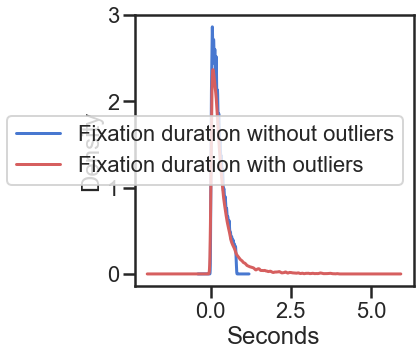

In [46]:
_, ax = plt.subplots(figsize=(5,5))
ax = (
    samples_df
    .query('isFix == 1 and isOutlierFix_1 ==0 and fix_duration_new!=0 and fix_duration_new <= 4')
    .fix_duration_new
    .plot(kind='kde',  label='Fixation duration without outliers', ax=ax)
    
)

ax = (
    samples_df
    .query('isFix == 1 and fix_duration_new!=0 and fix_duration_new <= 4')
    .fix_duration_new
    .plot(kind='kde',  ax = ax, color='r',label='Fixation duration with outliers')
)

ax.set_xlabel('Seconds')
ax.legend()

In [48]:
display(
    samples_df
    .query('isFix == 1 and isOutlierFix_1 ==0 and fix_duration_new!=0 and fix_duration_new <= 4')
    .fix_duration_new
    .describe()
)

display(
    samples_df
    .query('isFix == 1 and fix_duration_new!=0 and fix_duration_new <= 4')
    .fix_duration_new
    .describe()
)

count    4.188649e+06
mean     2.614643e-01
std      1.917631e-01
min      2.482174e-03
25%      1.106079e-01
50%      2.112958e-01
75%      3.774559e-01
max      8.005431e-01
Name: fix_duration_new, dtype: float64

count    4.726289e+06
mean     3.937121e-01
std      4.667279e-01
min      2.482174e-03
25%      1.220160e-01
50%      2.445290e-01
75%      4.776473e-01
max      3.954115e+00
Name: fix_duration_new, dtype: float64

In [ ]:
samples_df['grasp_start'] = (
    samples_df
    .groupby(['subject_id', 'trial_id', 'cue_name', 'familiarity', 'handle_orientation'], as_index=True)
    .toolIsCurrentlyAttachedToHand
    .apply(lambda x: 
           x
           .groupby((x != x.shift()).cumsum())
           .transform(lambda x: x.index[0])
    )
    
).reset_index().set_index('timestamp').toolIsCurrentlyAttachedToHand

In [ ]:
samples_df['grasp_start_bool'] = False
idx = samples_df.query('timestamp == grasp_start').index
samples_df.loc[idx, 'grasp_start_bool'] = True
# samples_df['grasp_start_bool'] = samples_df.toolIsCurrentlyAttachedToHand == samples_df.grasp_start

In [ ]:
 df = samples_df[
     samples_df
     .groupby(['subject_id', 'trial_id'])
     ['grasp_start_bool'].shift().ne(True) 
     & samples_df['grasp_start_bool']     
 ]
df.loc[:,['subject_id', 'trial_id']].head(10)

In [ ]:
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/02_fixations.csv', index=False)

In [4]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/02_fixations.csv')

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (109) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


count      mean       std       min       25%  \
interaction hit_object                                                   
LeapMotion  Environment  248.0  0.307968  0.158252  0.067567  0.191219   
            Tool         248.0  0.806091  0.144824  0.335660  0.726525   
controller  Environment  144.0  0.298951  0.088632  0.118056  0.230485   
            Tool         144.0  0.785879  0.102678  0.592354  0.701560   

                              50%       75%       max  
interaction hit_object                                 
LeapMotion  Environment  0.260391  0.407941  0.792868  
            Tool         0.842210  0.919179  0.994444  
controller  Environment  0.300137  0.356137  0.538034  
            Tool         0.788381  0.876041  0.986883

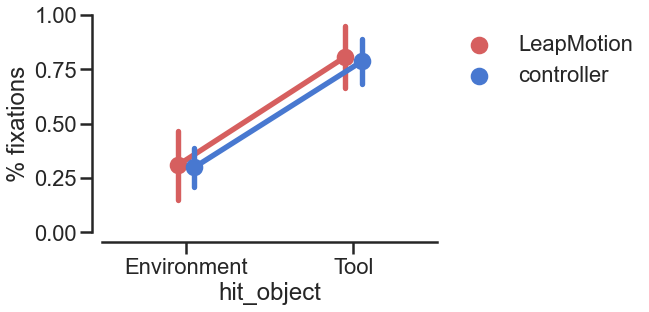

In [35]:
tmpdf = (
    samples_df
    .query('is_fixation == 1 and isOutlierFix_1==0 and fix_duration_new>=0.05 ')
    .query('time_since_start>=3 and time_since_start<=6')
    .drop_duplicates(subset=['subject_id', 'trial_id', 'isFix', 'fix_duration_new'], keep='first')    
)
tmpdf['hit_object'] = tmpdf.hit_object.map({'handle':'Tool', 'effector':'Tool'})
tmpdf['hit_object'] = tmpdf.hit_object.fillna('Environment')

tmpdf = (
    tmpdf
    .groupby(['subject_id','trial_id','cue_name','handle_orientation', 'familiarity','tool_name','hit_object'])
    .isFix
    .count()    
)
tmpdf = tmpdf.groupby(level=[0,1]).apply(lambda x: x/float(x.sum())).reset_index()
tmpdf = tmpdf.groupby(['subject_id', 'cue_name', 'handle_orientation', 'familiarity', 'hit_object']).isFix.mean().reset_index()
tmpdf['interaction'] = 'LeapMotion'
tmpdf.to_csv('perc_fixations_env_leap.csv')

tmpdf = pd.concat([tmpdf, pd.read_csv('perc_fixations_env_controller.csv')])

display(
    tmpdf
    .groupby(['interaction', 'hit_object'])
    .isFix
    .describe()
)

ax = sns.pointplot(
    data=tmpdf,
    x='hit_object',
    y='isFix',
    hue='interaction',
    ci='sd',
    dodge=0.1,
    palette=['r', 'b']
              
)
ax.set(
    ylim=(0,1),
    ylabel='% fixations'    
)
ax.legend(bbox_to_anchor=[1,1], frameon=False)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}/environment_differences.pdf', transparent=True, bbox_inches='tight', quality=90)

In [34]:
anova = pg.mixed_anova(
    data = (
        tmpdf
        .groupby(['subject_id', 'interaction', 'hit_object'])
        .isFix
        .mean()
        .reset_index()
    ), dv='isFix', subject='subject_id', within='hit_object', between='interaction')
display(anova)

Source        SS  DF1  DF2        MS           F         p-unc  \
0  interaction  0.004865    1   47  0.004865    2.866147  9.708058e-02   
1   hit_object  5.979147    1   47  5.979147  217.474720  2.967871e-19   
2  Interaction  0.000714    1   47  0.000714    0.025960  8.726887e-01   

        np2  eps  
0  0.057477  NaN  
1  0.822289  1.0  
2  0.000552  NaN

In [37]:
# Extract datapoints that hit on tooleffector or toolhandle 
tmpdf_fixations = (
    samples_df
    .rename(columns={'cue_name':'task', 'handle_orientation':'orientation'})
    .query('time_since_start>=3 and time_since_start<=6')
#     .query('subject_id in [32, 33, 36, 38, 43, 44, 45, 48]')
#     .query('orientation == "right"')
    .query('isFix == 1 and isOutlierFix_1==0 and fix_duration_new>=0.05 and hit_object in ["effector", "handle"]')
)

# Keep first datapoints per fixation
tmpdf_fixations = tmpdf_fixations.drop_duplicates(subset=['subject_id', 'trial_id', 'isFix', 'fix_duration_new'], keep='first') # trialids are unique across blocknumber

# Per trial odds for effector 
tmpdf_fixations_count = (
    tmpdf_fixations
    .query('fix_duration_new >=0.09')
    .groupby(['subject_id','trial_id','tool_name','task','orientation', 'familiarity','hit_object'])
    .isFix
    .count()
)
tmpdf_fixations_prop = tmpdf_fixations_count.groupby(level=[0,1]).apply(lambda x: x/float(x.sum()))
display(tmpdf_fixations_prop)
tmpdf_fixations_prop = tmpdf_fixations_prop.reset_index()
tmpdf = tmpdf_fixations_prop.query('hit_object == "effector"')
tmpdf['FixOdds'] = tmpdf.isFix/(1 - tmpdf.isFix) # odds (in favor) i.e. p/q vs probability i.e. p/(p+q)
tmpdf['FixLogOdds'] = np.log(tmpdf.FixOdds )
display(tmpdf)
tmpdf.replace(np.inf, 5, inplace=True)
tmpdf.replace(-np.inf, -5, inplace=True)
display(tmpdf.isna().mean())
display(tmpdf.loc[pd.isnull(tmpdf.FixOdds)])
# t = tmpdf.loc[pd.isnull(tmpdf.FixOdds)]
# display(t.orientation.value_counts(normalize=True))
# display(t.task.value_counts(normalize=True))
# display(t.subject_id.value_counts(normalize=0))

# tmpdf.dropna(inplace=True)
# display(tmpdf.columns)

subject_id  trial_id  tool_name     task  orientation  familiarity  hit_object
31          1         flowercutter  use   left         unfamiliar   effector      0.750000
                                                                    handle        0.250000
            2         trowel        lift  left         familiar     effector      0.285714
                                                                    handle        0.714286
            3         flowercutter  use   right        unfamiliar   effector      0.875000
                                                                                    ...   
61          141       fishscaler    use   left         unfamiliar   handle        1.000000
            142       spatula       lift  right        familiar     effector      1.000000
            143       spatula       use   left         familiar     effector      0.500000
                                                                    handle        0.500000
           

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


subject_id  trial_id     tool_name  task orientation familiarity  \
0             31         1  flowercutter   use        left  unfamiliar   
2             31         2        trowel  lift        left    familiar   
4             31         3  flowercutter   use       right  unfamiliar   
6             31         4        trowel   use       right    familiar   
7             31         5   screwdriver  lift        left    familiar   
...          ...       ...           ...   ...         ...         ...   
6369          61       138          fork   use       right    familiar   
6370          61       139    paintbrush  lift        left    familiar   
6372          61       140   spokewrench  lift        left  unfamiliar   
6375          61       142       spatula  lift       right    familiar   
6376          61       143       spatula   use        left    familiar   

     hit_object     isFix   FixOdds  FixLogOdds  
0      effector  0.750000  3.000000    1.098612  
2      effector  0.285714  0.400000   -0.916291  
4      effector  0.875000  7.000000    1.945910  
6      effector  1.000000       inf         inf  
7      effector  0.400000  0.666667   -0.405465  
...         ...       ...       ...         ...  
6369   effector  1.000000       inf         inf  
6370   effector  0.333333  0.500000   -0.693147  
6372   effector  0.200000  0.250000   -1.386294  
6375   effector  1.000000       inf         inf  
6376   effector  0.500000  1.000000    0.000000  

[3609 rows x 10 columns]

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


subject_id     0.0
trial_id       0.0
tool_name      0.0
task           0.0
orientation    0.0
familiarity    0.0
hit_object     0.0
isFix          0.0
FixOdds        0.0
FixLogOdds     0.0
dtype: float64

Empty DataFrame
Columns: [subject_id, trial_id, tool_name, task, orientation, familiarity, hit_object, isFix, FixOdds, FixLogOdds]
Index: []

In [12]:
display(
    tmpdf
    .groupby(['subject_id','task',])
    .agg({'FixLogOdds':'mean'})
    .reset_index()
    .groupby(['task',])
    .agg({'FixLogOdds':
          [
              np.mean,
              lambda x: np.mean(x) - 1.95*np.std(x)/np.sqrt(len(x)), #95% ci low
              lambda x: np.mean(x) + 1.95*np.std(x)/np.sqrt(len(x)) #95% ci high
              
          ]
    })
    .reset_index()
)
display(
    tmpdf
    .groupby(['subject_id', 'familiarity'])
    .agg({'FixLogOdds':'mean'})
    .reset_index()
    .groupby(['familiarity',])
    .agg({'FixLogOdds':
          [
              np.mean,
              lambda x: np.mean(x) - 1.95*np.std(x)/np.sqrt(len(x)), #95% ci low
              lambda x: np.mean(x) + 1.95*np.std(x)/np.sqrt(len(x)) #95% ci high
              
          ]
    })
    .reset_index()
)
display(
    tmpdf
    .groupby(['subject_id', 'orientation'])
    .agg({'FixLogOdds':'mean'})
    .reset_index()
    .groupby(['orientation', ])
    .agg({'FixLogOdds':
          [
              np.mean,
              lambda x: np.mean(x) - 1.95*np.std(x)/np.sqrt(len(x)), #95% ci low
              lambda x: np.mean(x) + 1.95*np.std(x)/np.sqrt(len(x)) #95% ci high
              
          ]
    })
    .reset_index()
)

task FixLogOdds                      
              mean <lambda_0> <lambda_1>
0  lift   0.089128  -0.047463   0.225720
1   use   0.227261   0.090569   0.363953

familiarity FixLogOdds                      
                    mean <lambda_0> <lambda_1>
0    familiar   0.042971  -0.083462   0.169405
1  unfamiliar   0.259905   0.122980   0.396829

orientation FixLogOdds                      
                    mean <lambda_0> <lambda_1>
0        left  -0.329252  -0.455752  -0.202751
1       right   1.183344   1.067784   1.298905

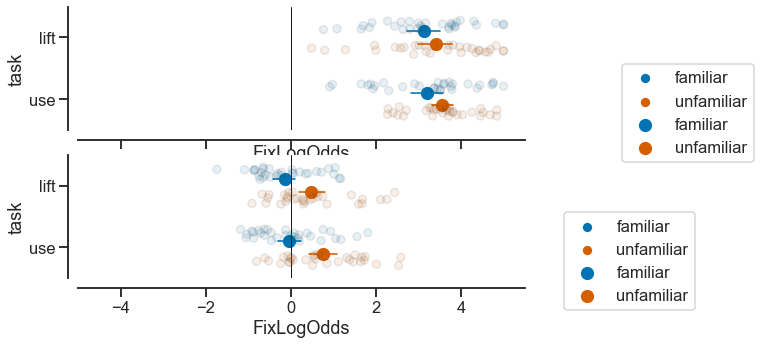

In [43]:
_, ax = plt.subplots(2, 1, figsize=(8,5), sharey=True, sharex=True)

sns.set(context='talk', style='ticks', palette='colorblind')
colors = sns.color_palette(palette='colorblind', n_colors=7)
tmpdf_plot = (
    tmpdf
    .groupby(['subject_id', 'task', 'familiarity', 'orientation',])
    .FixLogOdds
    .mean()
    .reset_index()
)
ax[0] = sns.stripplot(
    data=tmpdf_plot.query("orientation == 'right'"),
    y='task',
    x='FixLogOdds',
    palette=['b', 'r'],
        dodge=0.2,

    hue='familiarity',
    jitter=0.15,
    size=8,
    linewidth=1.5,
    alpha=0.1,
    ax=ax[0]
)

ax[0] = sns.pointplot(
    data=tmpdf_plot.query("orientation == 'right'"),
    y='task',
    x='FixLogOdds',  
    hue='familiarity',
    palette=['b', 'r'],
    join=False,
    ci=95,
    errwidth=1.6,
        dodge=0.2,

#     capsize=0.05,
    ax=ax[0]

)


ax[1] = sns.stripplot(
    data=tmpdf_plot.query("orientation == 'left'"),
    y='task',
    x='FixLogOdds',  
    hue='familiarity',
    palette=['b', 'r'],
    jitter=0.2,
        dodge=0.2,

    size=8,
    linewidth=1.5,
    alpha=0.1,
    ax=ax[1]
)

ax[1] = sns.pointplot(
    data=tmpdf_plot.query("orientation == 'left'"),
    y='task',
    x='FixLogOdds',  
    hue='familiarity',
    palette=['b', 'r'],
    join=False,
    ci=95,
    dodge=0.2,
    errwidth=1.6,
#     capsize=0.05,
    ax=ax[1]
)

ax[0].set(
    xticks=[-5, -2.19722458 , -1.09861229, 0., 1.09861229, 2.19722458, 5],
#     xticklabels=['0:100', '25:75', '50:50', '75:25', '100:0'],
#     xlabel='',
#     xlim=(-2.19722458, 2.19722458)
)
ax[1].set(
#     xticks=[-2.19722458 , -1.09861229, 0., 1.09861229, 2.19722458 ],
#     xticklabels=['0:100', '25:75', '50:50', '75:25', '100:0'],
    xlim=(-5,5.5)
)
ax[0].legend(bbox_to_anchor=[1.2, 0.6])
ax[0].axvline(0, ls='-', color='k', lw=1)
ax[1].legend(bbox_to_anchor=[1.4, 0.6])
ax[1].axvline(0, ls='-', color='k', lw=1)
sns.despine(offset=10)

# plt.savefig(f'{PLOT_PATH}/log_odds_leap_subject_scale.pdf', transparent=True, bbox_inches='tight', quality=90)

In [ ]:
s = tmpdf.groupby(['subject_id','task','orientation', 'familiarity']).size().reset_index(name='trial_size')#.plot(kind='hist', bins=36)
# s[s==1].index.values
sns.catplot(
    data = s,
    x='subject_id',
    y='trial_size',
    hue='orientation',
    row='familiarity',
    kind='bar',
    height=5, aspect=3
)
# display(s.head(20))
display(s.query('subject_id==32'))

In [78]:
s = tmpdf.groupby('subject_id').trial_id.count()
bad_subjects = s[s<72].index.values

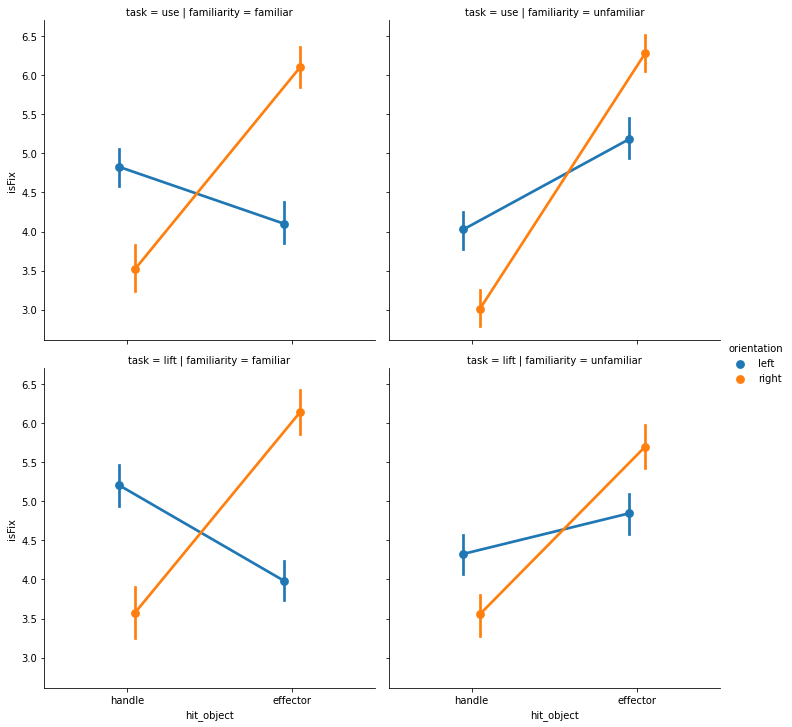

In [46]:
ax = sns.catplot(
    data=tmpdf_fixations_count.reset_index(), 
    x='hit_object', 
    y='isFix', 
    col='familiarity', 
    row='task',
    kind='point', 
    hue='orientation',
    dodge=0.1,
#     split=True,
    col_order=['familiar', 'unfamiliar'],
    order=['handle', 'effector'],
    ci=95,
#     join=False
#             ax=ax
)
# ax.set(
#     yticks=[-2, -1, 0, 1, 2]
# );

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


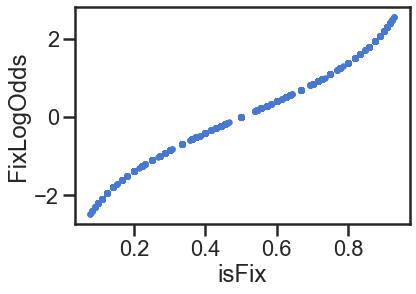

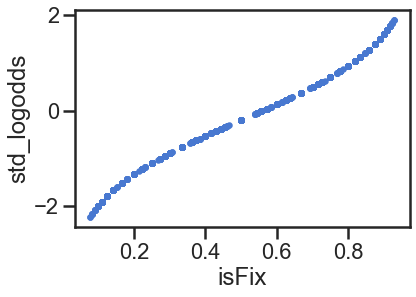

In [125]:
tmpdf.plot.scatter(x='isFix', y='FixLogOdds')
tmpdf.plot.scatter(x='isFix', y='std_logodds')

In [124]:
tmpdf['std_logodds'] = (tmpdf.FixLogOdds - tmpdf.FixLogOdds.mean())/tmpdf.FixLogOdds.std()

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


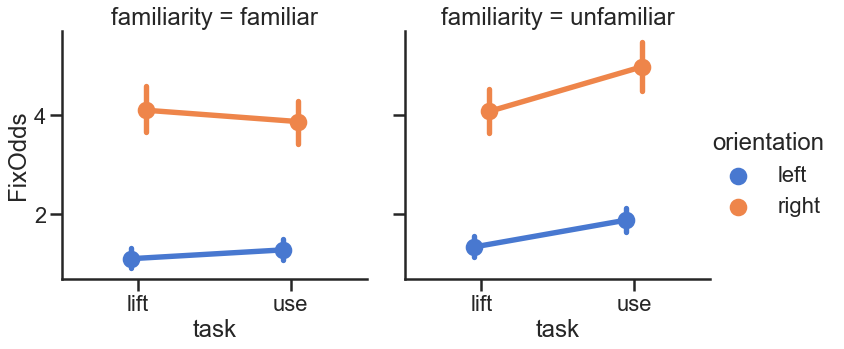

In [69]:
sns.set(style='ticks', context='poster', palette='muted')
ax = sns.catplot(data=tmpdf.query('subject_id not in @bad_subjects'), 
            x='task', 
            y='FixOdds', 
            col='familiarity', 
            kind='point', 
            hue='orientation',
            dodge=0.1,
            col_order=['familiar', 'unfamiliar'],
            order=['lift', 'use'],
            ci=95,
#             ax=ax
)
ax.set(
#     yticks=[-2, 0, 2],

)


In [99]:
display(tmpdf.FixLogOdds.mean()) 
display(tmpdf.std_scaled.mean())

0.24196974441575264

5.991085461720912e-18

In [42]:
(
    tmpdf
#     .query('subject_id not in @bad_subjects')
#     .query('subject_id in [32, 33, 36, 38, 39, 40, 42, 43, 44, 45, 48, 50, 53, 54, 58]')
#     .rename(columns={'task':'cue', 'tool_name':'tool'})
    .to_csv(f'./exp2_model_input_1.csv', index=False)
)

In [131]:
tmpdf.query('subject_id not in [31, 34, 35, 37, 41, 46, 47, 49, 51, 52, 55, 56, 57, 61]').subject_id.nunique()

17

In [75]:
meta_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/00_meta_leap.csv') 

meta_df= meta_df[['subjectId', 'toolDetails']]
display(meta_df.head())

loaded_tool_json = json.loads(meta_df.iloc[0].toolDetails.replace("'","\""))
tool_details_df = pd.json_normalize(loaded_tool_json)

tool_sizes_df = tool_details_df.drop(
    columns=['toolAttachmentPointsSteamVr','toolAttachmentPointsLeapMotion',
             'toolPivotBottomCenterOffset.x','toolPivotBottomCenterOffset.y',
             'toolPivotBottomCenterOffset.z','toolHandleCollider.m_FileID',
             'toolHandleCollider.m_PathID','toolEffectorCollider.m_FileID',
             'toolEffectorCollider.m_PathID']
)

# Extract all colliders
tool_colliders_df = pd.concat(
    [pd.DataFrame(
        pd.json_normalize(x)) for x in tool_sizes_df['toolColliders']
    ],
    ignore_index=True)

tool_colliders_df = tool_colliders_df.drop(
    tool_colliders_df[tool_colliders_df['colliderName'].str.contains("Manual")].index
)
tool_colliders_df = tool_colliders_df.drop(columns=['collider.m_FileID','collider.m_PathID'])

tool_colliders_df

# SCRATCH

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

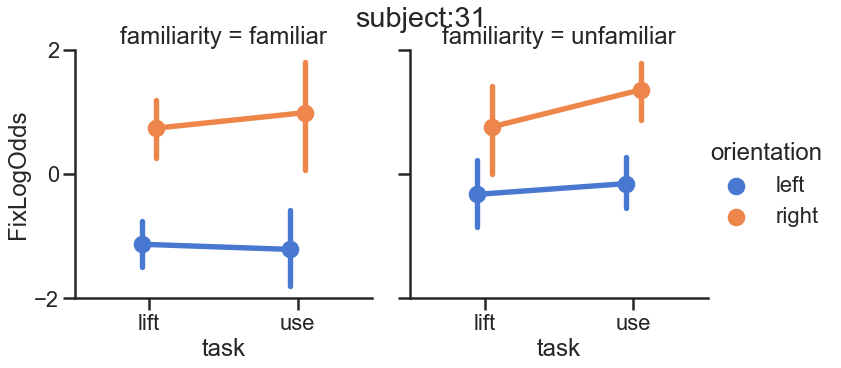

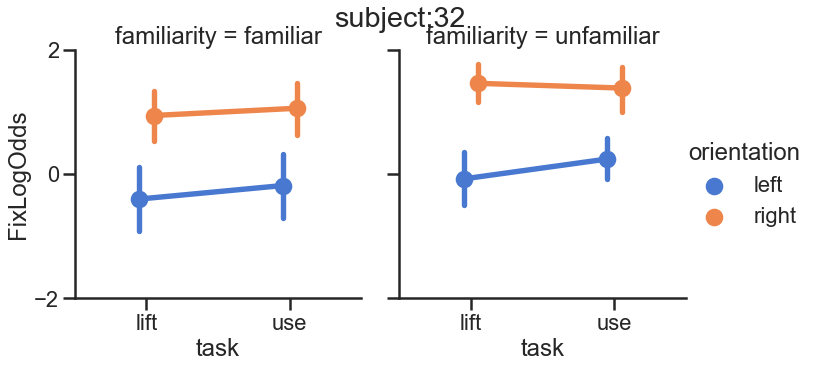

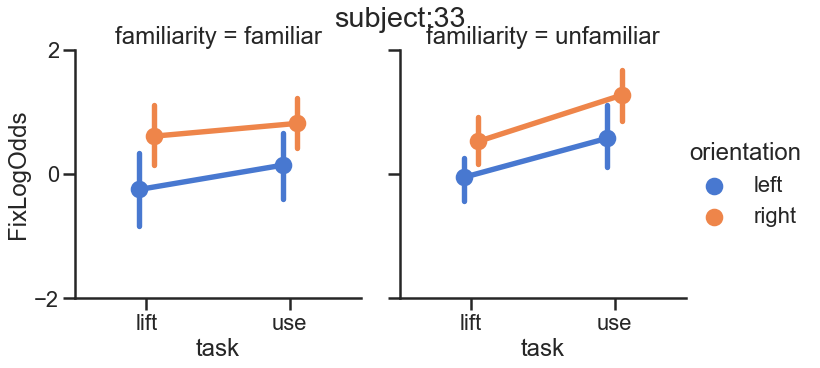

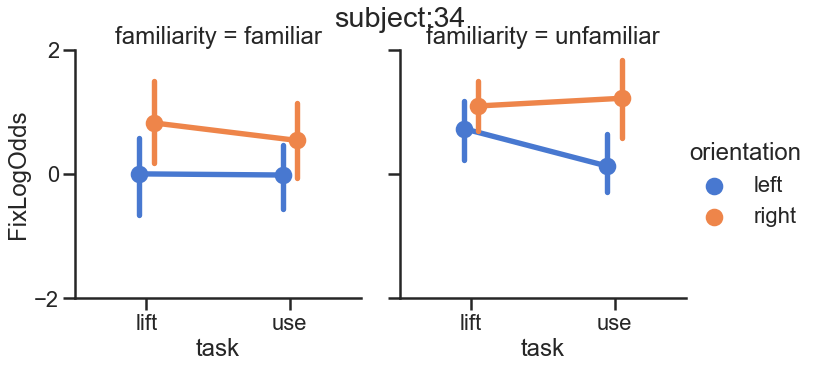

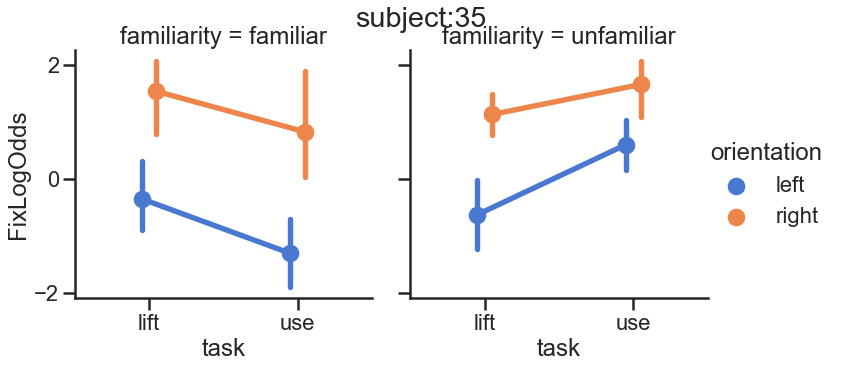

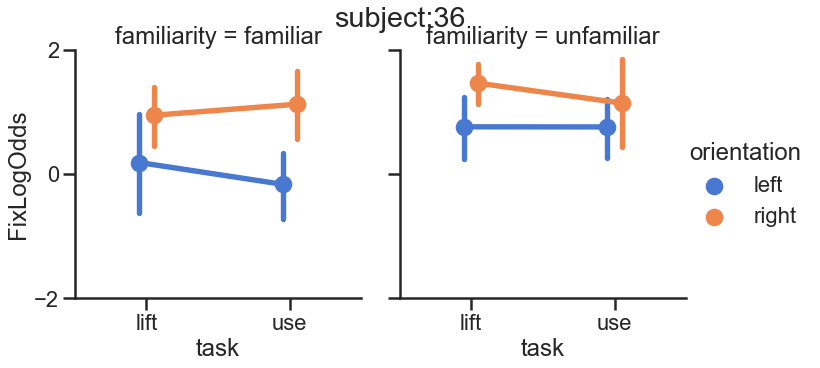

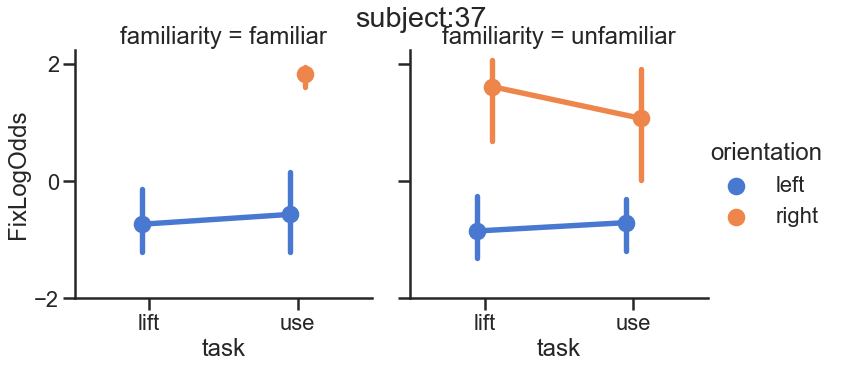

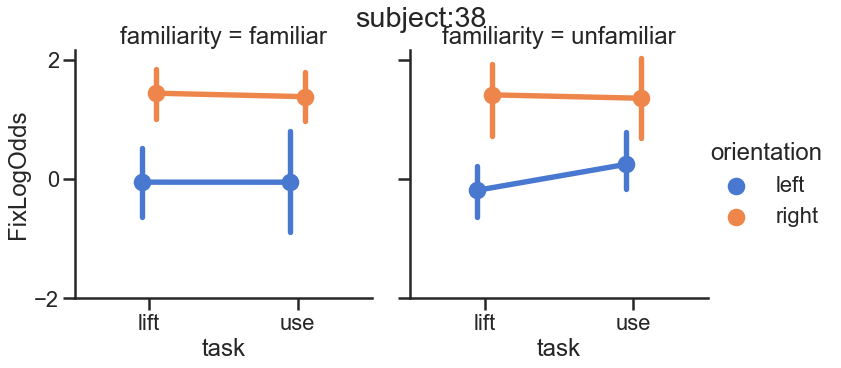

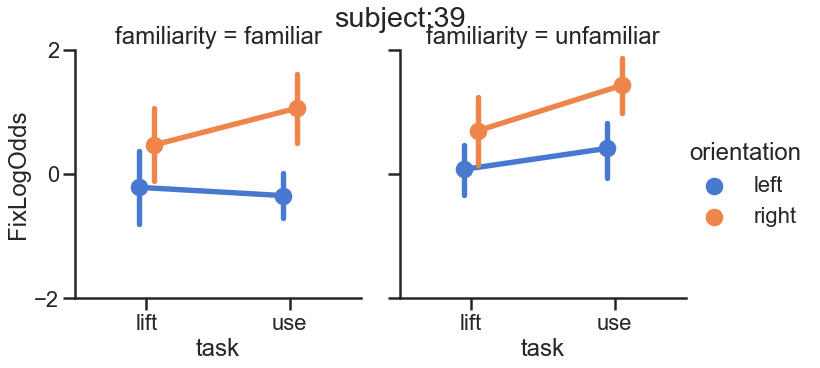

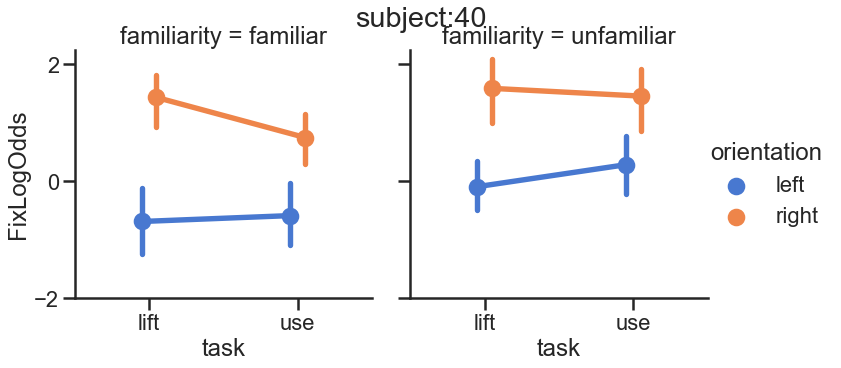

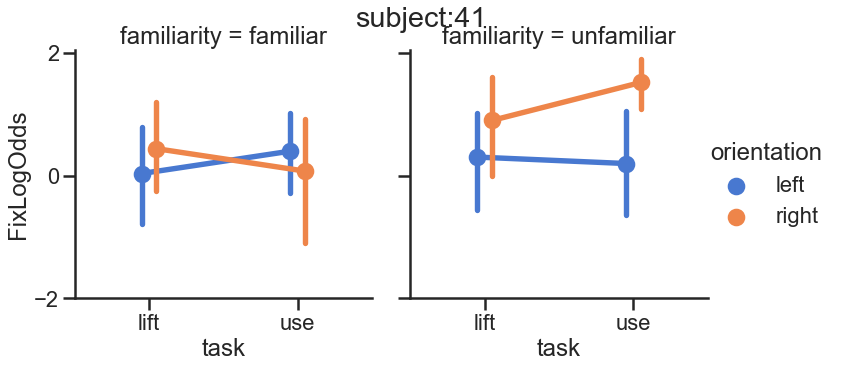

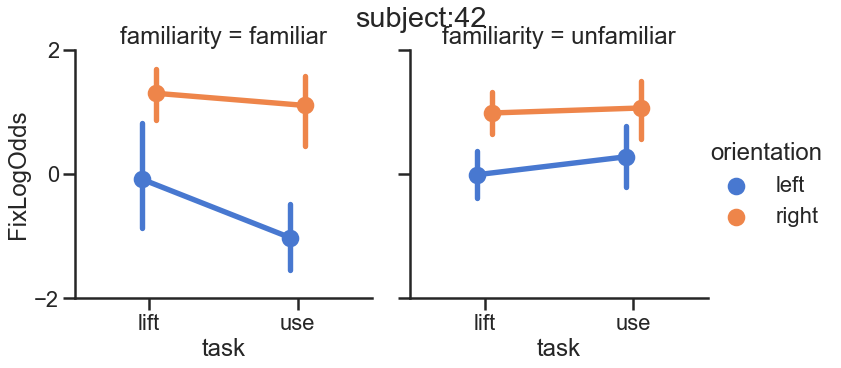

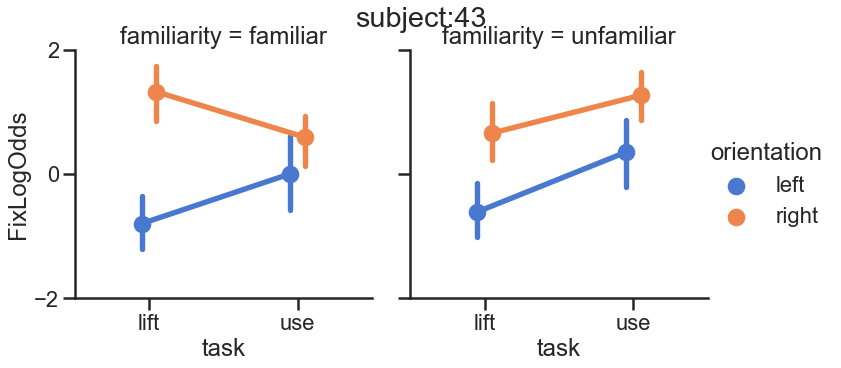

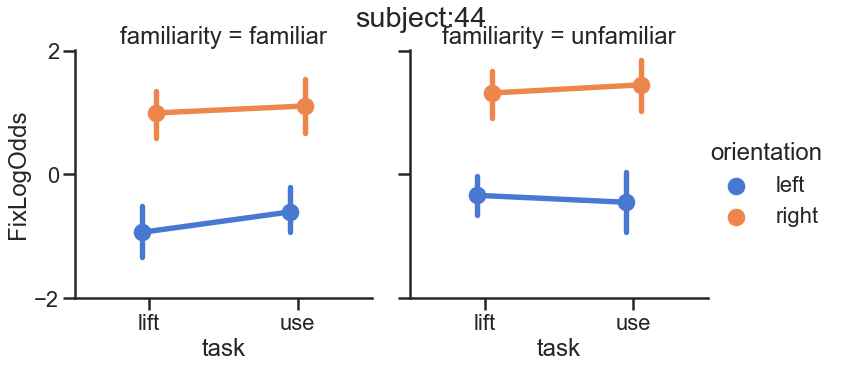

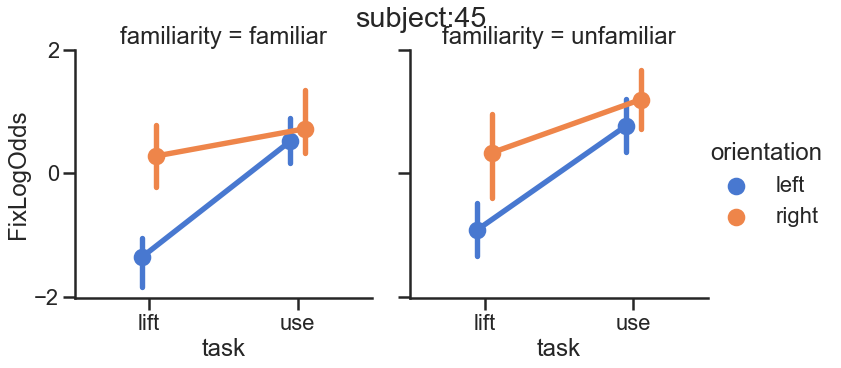

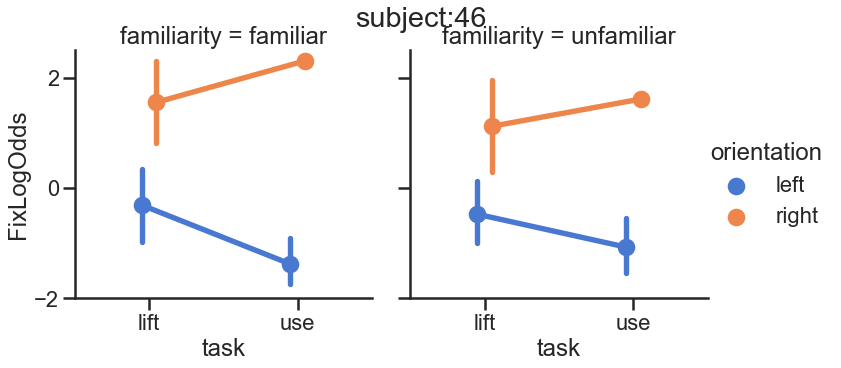

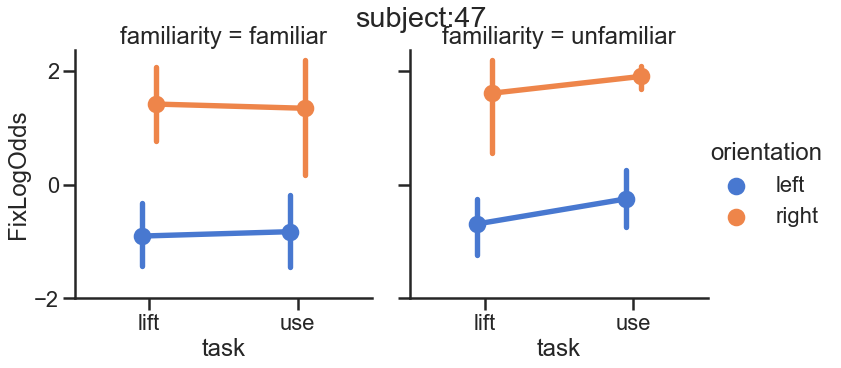

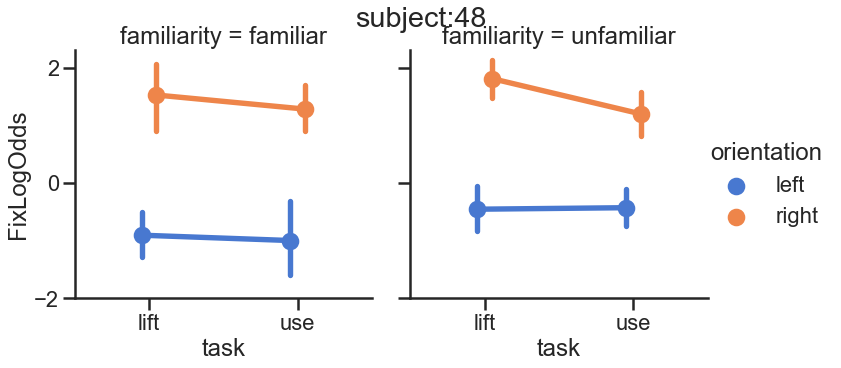

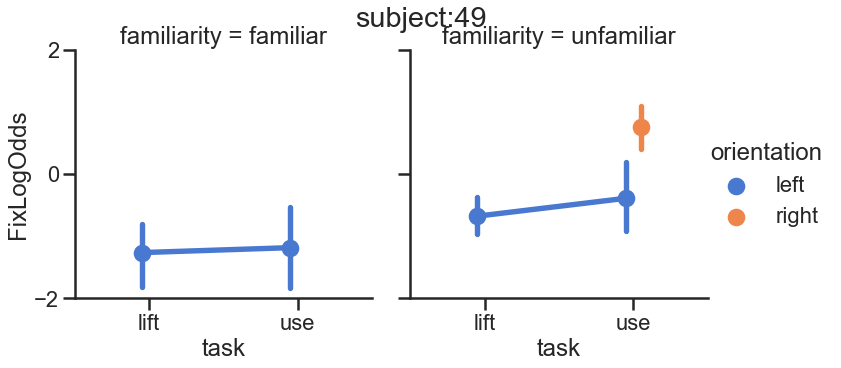

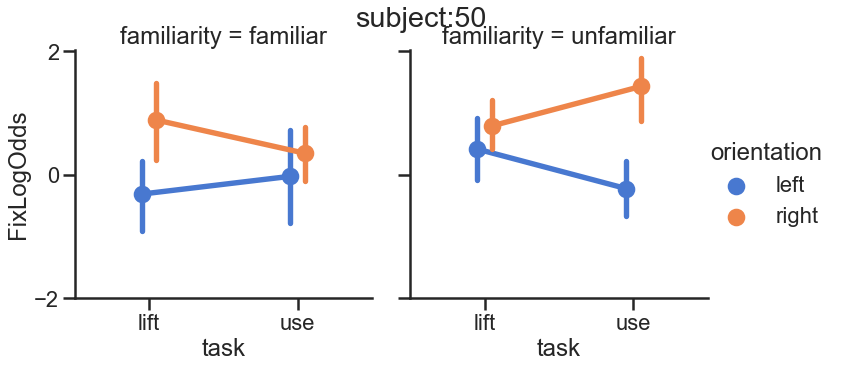

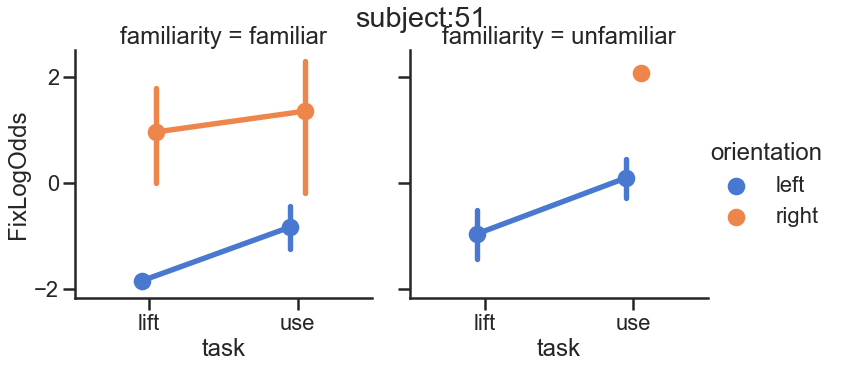

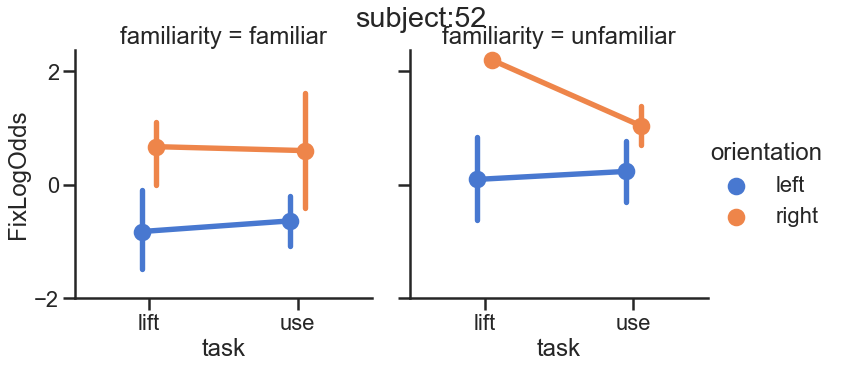

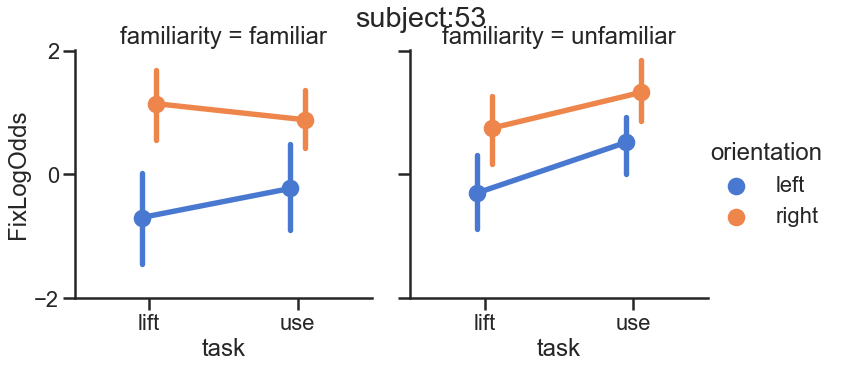

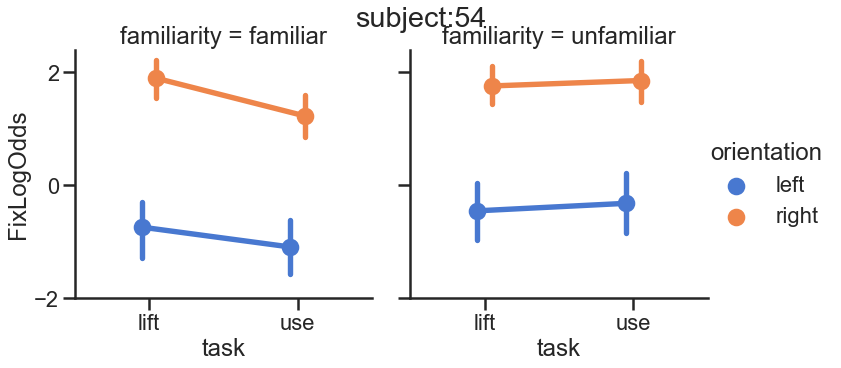

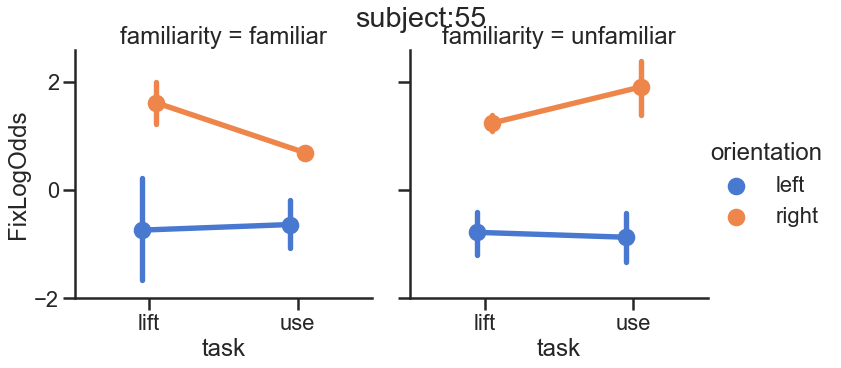

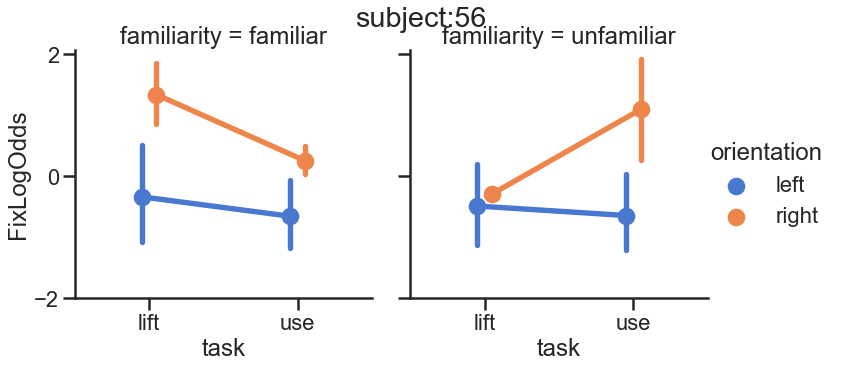

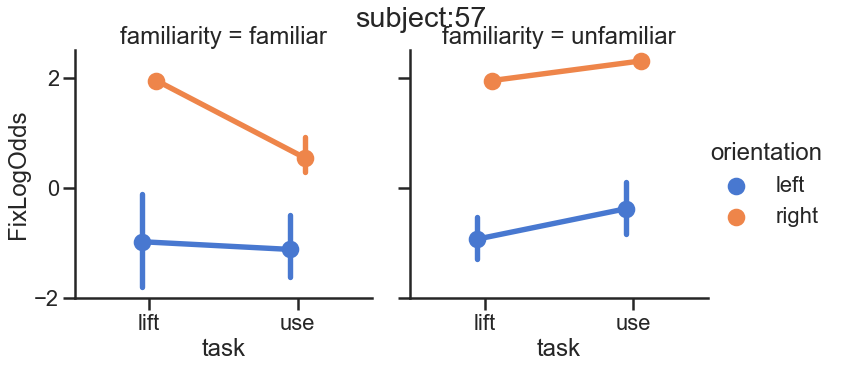

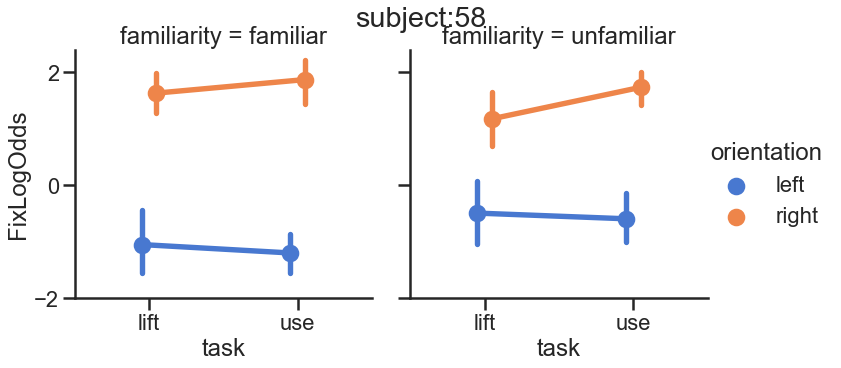

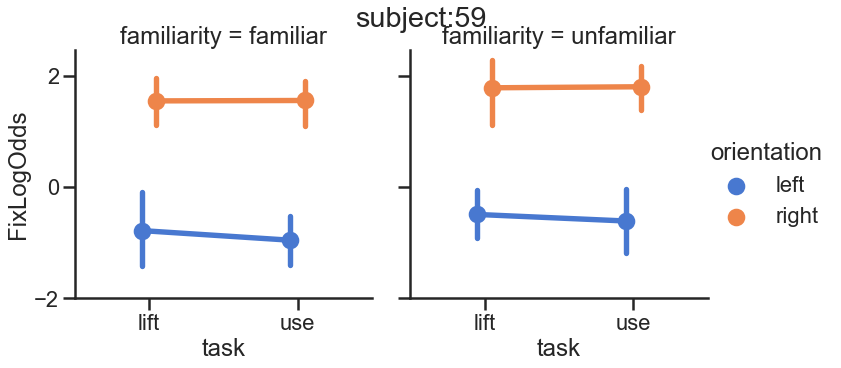

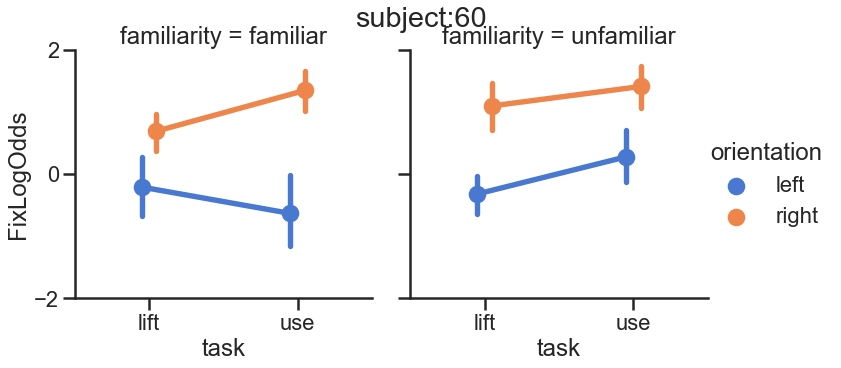

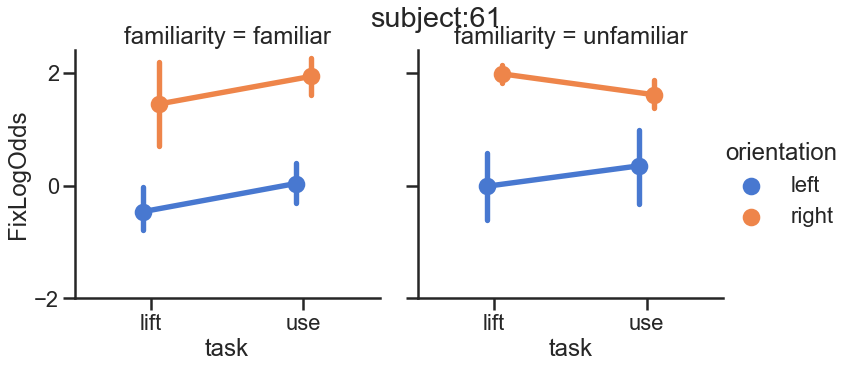

In [57]:
for subject in tmpdf.subject_id.unique():
    ax = sns.catplot(data=tmpdf.query('subject_id==@subject'), 
                x='task', 
                y='FixLogOdds', 
                col='familiarity', 
                kind='point', 
                hue='orientation',
                dodge=0.1,
                col_order=['familiar', 'unfamiliar'],
                order=['lift', 'use'],
                hue_order=['left', 'right'],
                ci=95,
    #             ax=ax
    )
    ax.set(
        yticks=[-2, 0, 2,],
        
    )
    ax.fig.suptitle(f'subject:{subject}')

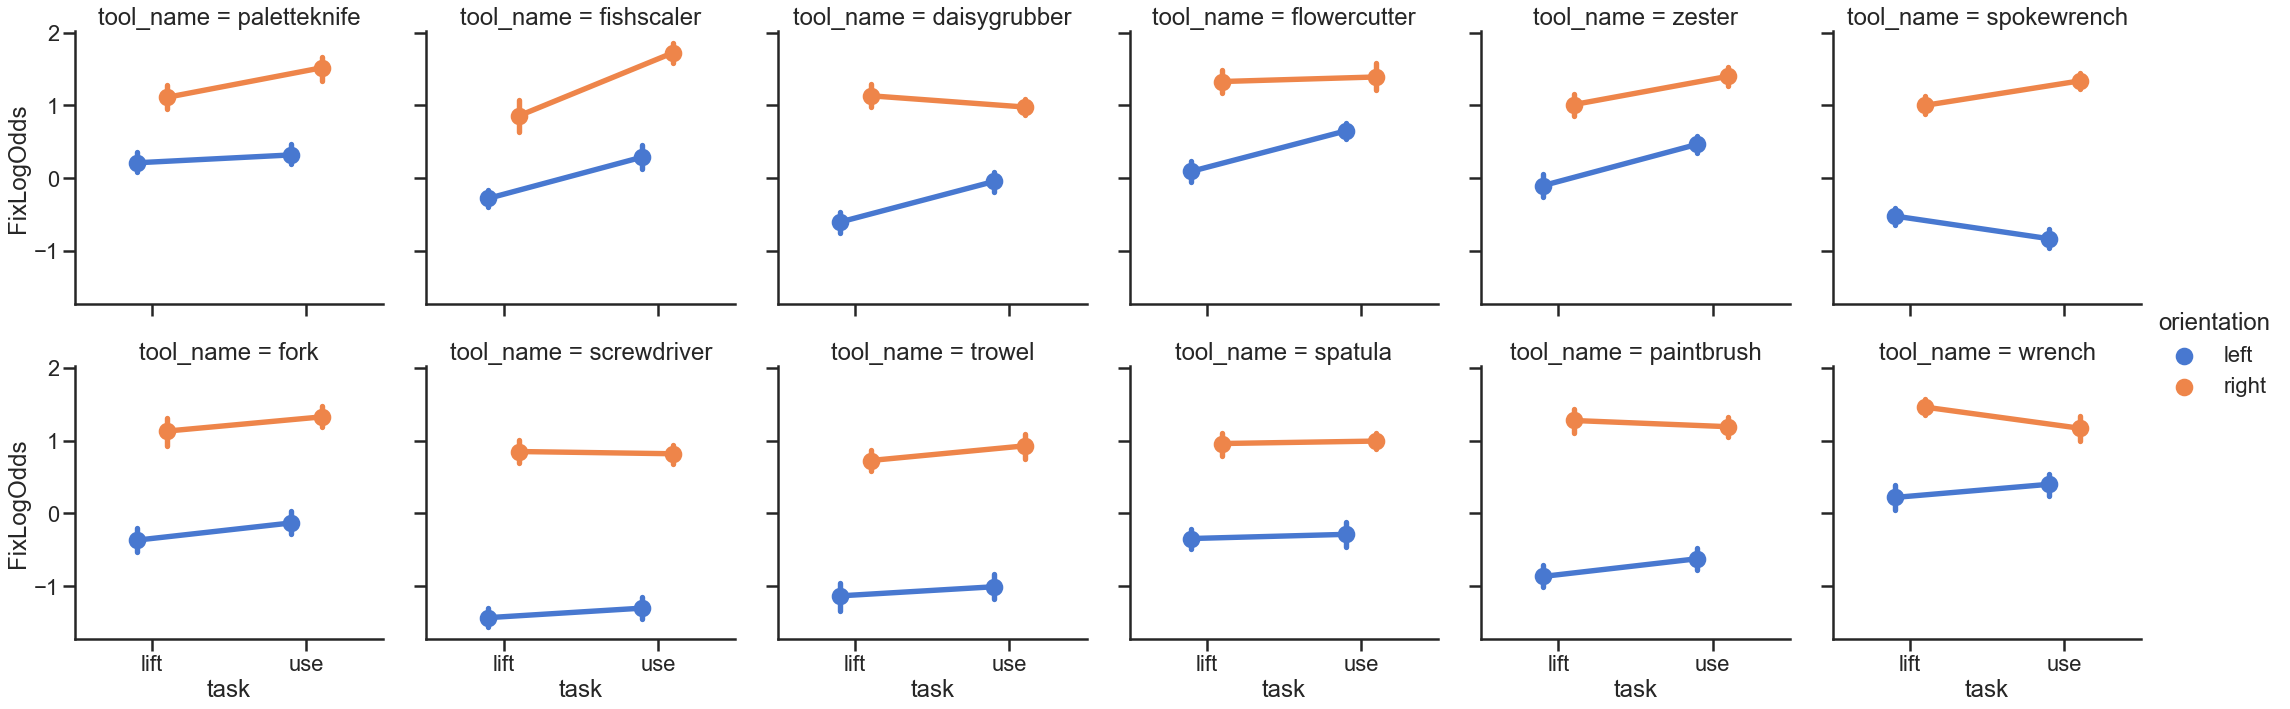

In [71]:
tool_names = ['paletteknife','fishscaler','daisygrubber', 'flowercutter', 'zester', 'spokewrench',
              'fork','screwdriver','trowel', 'spatula','paintbrush','wrench']
sns.catplot(data=tmpdf.query('subject_id not in @bad_subjects'), 
            x='task', 
            y='FixLogOdds', 
            hue='orientation', 
            col='tool_name',
            col_wrap=6,
            col_order=tool_names,
            kind='point', 
            dodge=0.2,
            order=['lift', 'use'],
            ci=68
);

In [ ]:
import statsmodels as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from patsy.contrasts import ContrastMatrix
import scipy.stats as spstat
import patsy
data = tmpdf.query('subject_id not in [51, 57, 37]')
endog, exog = patsy.dmatrices('''FixLogOdds ~ 1 +
                              C(task,Sum) * 
                              C(familiarity,Sum) * 
                              C(orientation,Sum)
                              ''',
                             data)
# groups = patsy.dmatrix('subjectID', tmpdf)
# formula = '''isFix ~ 1 + C(cue, EffectCoding) * 
#             C(Familiarity, EffectCoding) * 
#             C(orientation, EffectCoding) * 
#             C(hitToolPart, EffectCoding)'''
# re_exog = patsy.dmatrix(re_formula, data = tmpdf)
model = sm.regression.mixed_linear_model.MixedLM(endog, exog, groups=data['subject_id'], use_sqrt=True)
result = model.fit()
display(result.summary())
display(pd.DataFrame(result.cov_re))

In [ ]:
tmpdf['FixLag'] = (tmpdf
                     .groupby(['subject_id'])
                     ['FixLogOdds']
                     .transform(lambda x: x.shift())
                    )
_, ax = plt.subplots(figsize=(10,10))
for sub in tmpdf.subject_id.unique():
    sns.regplot(y='FixLogOdds', 
                x='FixLag', 
                data=tmpdf.query('subject_id == @sub '),
                ax=ax,
                label=f'subject_{sub}'
    )
# ax.set(
#     xlim=(-3,3),
#     ylim=(-5, 5)
# )
ax.legend(bbox_to_anchor=(1,1));
